In [1]:
# basic libraries needed
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import copy
import tensorflow as tf
import keras.api._v2.keras as keras
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import array

In [2]:
data_hor=pd.read_csv("Data/combined_data_hor.csv")
data_hor = data_hor.drop('Unnamed: 0', axis=1)

In [3]:
from sklearn.preprocessing import MinMaxScaler
power_list = [i for i in data_hor.columns]
scaler = MinMaxScaler()

perc=0.95

train_size = int(len(data_hor) * perc)
test_size = len(data_hor) - train_size
df_train = data_hor[0:train_size]
df_test = data_hor[train_size:len(data_hor)]

# scaled_train = scaler.fit_transform(df_train[power_list])
# scaled_test = scaler.transform(df_test[power_list])

scaled_train_and_test = scaler.fit_transform(data_hor[power_list])
scaled_train = scaled_train_and_test[0:train_size]
scaled_test = scaled_train_and_test[train_size:len(data_hor)]

In [4]:
def split_sequence(sequence, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [5]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape)

In [6]:
LOOK_BACK=500
FORECAST_RANGE=20

## making the look_back according to the main frequency since the data are kindly periodic

n_features=len(power_list)

X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(30980, 500, 40)
(30980, 20, 40)
(12982, 500, 40)
(12982, 20, 40)


In [7]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

In [8]:
epochs = 50
batch_size = 32
validation = 0.1

In [9]:
checkpoint_filepath = 'improvementsModel_combinedData_20_mac_CNN_LSTM/weights-improvement-{epoch:06d}-{val_loss:.6f}.hdf5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.005,
    patience=10,
    mode='min'
)
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min', patience=3, min_lr=0.005)

In [10]:
## CNN-LSTM Encoder - Decoder Model

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation='tanh', input_shape=(LOOK_BACK, n_features)))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation='tanh'))
model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())
model_enc_dec_cnn.add(RepeatVector(FORECAST_RANGE))
model_enc_dec_cnn.add(LSTM(200, activation='tanh', return_sequences=True))
model_enc_dec_cnn.add(TimeDistributed(Dense(100, activation='tanh')))
model_enc_dec_cnn.add(TimeDistributed(Dense(n_features)))
model_enc_dec_cnn.compile(loss='mse', optimizer='adam')

plot_model(model=model_enc_dec_cnn, show_shapes=True)
history = model_enc_dec_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])
yhat = model_enc_dec_cnn.predict(X_test, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
evaluate_forecast(y_test_inverse, yhat_inverse)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/50


2023-01-15 21:26:15.569584: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


872/872 [==============================] - 330s 376ms/step - loss: 0.0687 - val_loss: 0.0650 - lr: 0.0010
Epoch 2/50
872/872 [==============================] - 1914s 2s/step - loss: 0.0678 - val_loss: 0.0651 - lr: 0.0010
Epoch 3/50
872/872 [==============================] - 1885s 2s/step - loss: 0.0677 - val_loss: 0.0648 - lr: 0.0010
Epoch 4/50
872/872 [==============================] - 1025s 1s/step - loss: 0.0676 - val_loss: 0.0646 - lr: 0.0010
Epoch 5/50
872/872 [==============================] - 2337s 3s/step - loss: 0.0675 - val_loss: 0.0646 - lr: 0.0010
Epoch 6/50
872/872 [==============================] - 2140s 2s/step - loss: 0.0673 - val_loss: 0.0645 - lr: 0.0010
Epoch 7/50
872/872 [==============================] - 2273s 3s/step - loss: 0.0672 - val_loss: 0.0644 - lr: 0.0010
Epoch 8/50
872/872 [==============================] - 3465s 4s/step - loss: 0.0672 - val_loss: 0.0641 - lr: 0.0010
Epoch 9/50
872/872 [==============================] - 4168s 5s/step - loss: 0.0671 - val_

In [11]:
input_layer = Input(shape=(LOOK_BACK, n_features)) 
head_list = []
for i in range(0, n_features):
    conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='tanh')(input_layer)
    conv_layer_head_2 = Conv1D(filters=6, kernel_size=11, activation='tanh')(conv_layer_head)
    conv_layer_flatten = Flatten()(conv_layer_head_2)
    head_list.append(conv_layer_flatten)
 
concat_cnn = Concatenate(axis=1)(head_list)
reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)
lstm = LSTM(100, activation='tanh')(reshape)
repeat = RepeatVector(FORECAST_RANGE)(lstm)
lstm_2 = LSTM(100, activation='tanh', return_sequences=True)(repeat)
dropout = Dropout(0.2)(lstm_2)
dense = Dense(n_features, activation='linear')(dropout)
multi_head_cnn_lstm_model = Model(inputs=input_layer, outputs=dense)

Text(0, 0.5, 'MAPE')

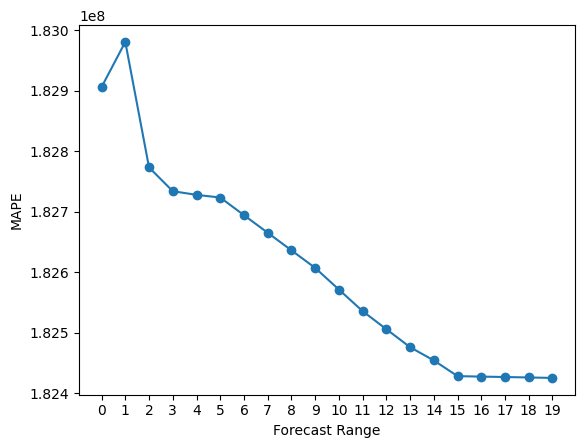

In [12]:
y_test_inverse_time_step = y_test_inverse.reshape(int(y_test_inverse.shape[0]/FORECAST_RANGE), FORECAST_RANGE, y_test_inverse.shape[-1])
yhat_inverse_time_step = yhat_inverse.reshape(int(yhat_inverse.shape[0]/FORECAST_RANGE), FORECAST_RANGE, yhat_inverse.shape[-1])
# yhat_inverse_time_step and y_test_inverse_time_step are both same dimension.
time_step_list_yhat = [[] for i in range(FORECAST_RANGE)]
time_step_list_y_test = [[] for i in range(FORECAST_RANGE)]
for i in range(0, yhat_inverse_time_step.shape[0]):
 for j in range(0, yhat_inverse_time_step.shape[1]):
    time_step_list_yhat[j].append(list(yhat_inverse_time_step[i][j]))
    time_step_list_y_test[j].append(list(y_test_inverse_time_step[i][j]))
yhat_time_step = np.array(time_step_list_yhat)
yhat_time_step = yhat_time_step.reshape(yhat_time_step.shape[0], -1)
y_test_time_step = np.array(time_step_list_y_test)
y_test_time_step = y_test_time_step.reshape(y_test_time_step.shape[0], -1)
# plotting
mape_list = []
for i in range(0, FORECAST_RANGE):
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mape = mape_(y_test_time_step[i], yhat_time_step[i])
    mape_list.append(mape)
plt.plot(range(0, FORECAST_RANGE), mape_list, marker='o')
plt.xticks((range(0, FORECAST_RANGE)))
plt.xlabel('Forecast Range')
plt.ylabel('MAPE')

Text(0, 0.5, 'MAE')

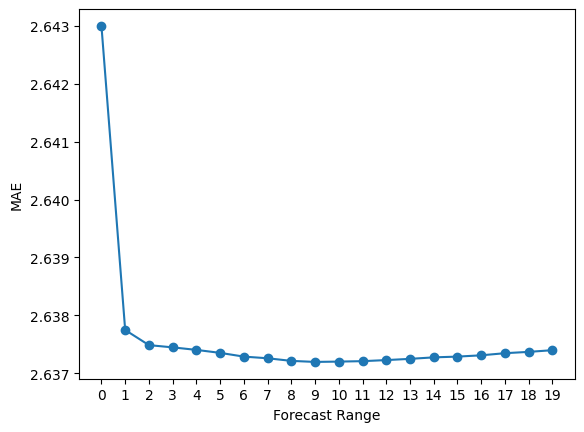

In [16]:
y_test_inverse_time_step = y_test_inverse.reshape(int(y_test_inverse.shape[0]/FORECAST_RANGE), FORECAST_RANGE, y_test_inverse.shape[-1])
yhat_inverse_time_step = yhat_inverse.reshape(int(yhat_inverse.shape[0]/FORECAST_RANGE), FORECAST_RANGE, yhat_inverse.shape[-1])
# yhat_inverse_time_step and y_test_inverse_time_step are both same dimension.
time_step_list_yhat = [[] for i in range(FORECAST_RANGE)]
time_step_list_y_test = [[] for i in range(FORECAST_RANGE)]
for i in range(0, yhat_inverse_time_step.shape[0]):
 for j in range(0, yhat_inverse_time_step.shape[1]):
    time_step_list_yhat[j].append(list(yhat_inverse_time_step[i][j]))
    time_step_list_y_test[j].append(list(y_test_inverse_time_step[i][j]))
yhat_time_step = np.array(time_step_list_yhat)
yhat_time_step = yhat_time_step.reshape(yhat_time_step.shape[0], -1)
y_test_time_step = np.array(time_step_list_y_test)
y_test_time_step = y_test_time_step.reshape(y_test_time_step.shape[0], -1)
# plotting
mae_list = []
for i in range(0, FORECAST_RANGE):
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mae = mae_(y_test_time_step[i], yhat_time_step[i])
    mae_list.append(mae)
plt.plot(range(0, FORECAST_RANGE), mae_list, marker='o')
plt.xticks((range(0, FORECAST_RANGE)))
plt.xlabel('Forecast Range')
plt.ylabel('MAE')

In [13]:
for i in range(0, n_features):
    print('->', i)
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse[:,i],yhat_inverse[:,i])
    print('mae:', mae)
    mse = mse_(y_test_inverse[:,i],yhat_inverse[:,i])
    print('mse:', mse)
    mape = mape_(y_test_inverse[:,i],yhat_inverse[:,i])
    print('mape:', mape)

-> 0
mae: tf.Tensor(0.17374974, shape=(), dtype=float32)
mse: tf.Tensor(0.064094014, shape=(), dtype=float32)
mape: tf.Tensor(4664305.5, shape=(), dtype=float32)
-> 1
mae: tf.Tensor(0.078498006, shape=(), dtype=float32)
mse: tf.Tensor(0.014385108, shape=(), dtype=float32)
mape: tf.Tensor(713524.7, shape=(), dtype=float32)
-> 2
mae: tf.Tensor(0.4543009, shape=(), dtype=float32)
mse: tf.Tensor(0.33385754, shape=(), dtype=float32)
mape: tf.Tensor(58750176.0, shape=(), dtype=float32)
-> 3
mae: tf.Tensor(0.12187123, shape=(), dtype=float32)
mse: tf.Tensor(0.038197953, shape=(), dtype=float32)
mape: tf.Tensor(11.873579, shape=(), dtype=float32)
-> 4
mae: tf.Tensor(0.70669544, shape=(), dtype=float32)
mse: tf.Tensor(0.88410044, shape=(), dtype=float32)
mape: tf.Tensor(90994310.0, shape=(), dtype=float32)
-> 5
mae: tf.Tensor(0.17194022, shape=(), dtype=float32)
mse: tf.Tensor(0.10439879, shape=(), dtype=float32)
mape: tf.Tensor(2421724.8, shape=(), dtype=float32)
-> 6
mae: tf.Tensor(1.1955074,

In [14]:
# def create_model(units, dropout_rate):
#   model = Sequential()
#   # Add layers to your model here
#   model.add(Dense(units, input_shape=input_shape))
#   model.add(Dropout(dropout_rate))
#   # Add more layers as needed
#   model.compile(loss='mean_squared_error', optimizer='adam')
#   return model

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, RepeatVector, LSTM, TimeDistributed, Dense

def create_model(batch_size=16, units=16, dropout_rate=0.2, epochs=20):
    model_enc_dec_cnn = Sequential()
    model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation='tanh', input_shape=(LOOK_BACK, n_features)))
    model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation='tanh'))
    model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
    model_enc_dec_cnn.add(Flatten())
    model_enc_dec_cnn.add(RepeatVector(FORECAST_RANGE))
    model_enc_dec_cnn.add(LSTM(units, activation='tanh', return_sequences=True, dropout=dropout_rate))
    model_enc_dec_cnn.add(TimeDistributed(Dense(100, activation='tanh')))
    model_enc_dec_cnn.add(TimeDistributed(Dense(n_features)))
    model_enc_dec_cnn.compile(loss='mse', optimizer='adam')
    model_enc_dec_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])
    return model_enc_dec_cnn



In [15]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from joblib import Parallel, delayed
# from scikeras.wrappers import KerasRegressor

# Define the input shape
input_shape = (LOOK_BACK, n_features)

# Create the model
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the parameter grid
# param_grid = {
#     'batch_size': [16, 32, 64, 128, 256, 512],
#     'epochs': [10, 20, 30, 40, 50, 100, 200],
#     'units': [16, 32, 64, 128, 256, 512],
#     'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
# }

param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [10, 20],
    'units': [16, 32, 64],
    'dropout_rate': [0.2, 0.3, 0.4]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=1, verbose=1)

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=1, verbose=1, pre_dispatch='2*n_jobs')

# Parallelize the grid search
# results = Parallel(n_jobs=-1, verbose=1)(delayed(grid_search.fit)(X_train, y_train) for i in range(num_repeats))

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

# Evaluate the model with the best hyperparameters on the test data
best_model = grid_search.best_estimator_
yhat = best_model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
yhat_inverse = scaler.inverse_transform(yhat)
evaluate_forecast(y_test_inverse, yhat_inverse)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


/var/folders/5v/snpvy65x6rx4rzv00_hsqsq80000gn/T/ipykernel_3426/3499058785.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Epoch 1/10
1743/1743 [==============================] - 687s 393ms/step - loss: 0.0684 - val_loss: 0.0642 - lr: 0.0010
Epoch 2/10
1743/1743 [==============================] - 1379s 792ms/step - loss: 0.0670 - val_loss: 0.0643 - lr: 0.0010
Epoch 3/10
1743/1743 [==============================] - 101s 58ms/step - loss: 0.0669 - val_loss: 0.0641 - lr: 0.0010
Epoch 4/10
1743/1743 [==============================] - 1641s 942ms/step - loss: 0.0668 - val_loss: 0.0642 - lr: 0.0010
Epoch 5/10
1743/1743 [==============================] - 2023s 1s/step - loss: 0.0668 - val_loss: 0.0640 - lr: 0.0010
Epoch 6/10
1743/1743 [==============================] - 1055s 605ms/step - loss: 0.0667 - val_loss: 0.0640 - lr: 0.0010
Epoch 7/10
1743/1743 [==============================] - 580s 333ms/step - loss: 0.0667 - val_loss: 0.0640 - lr: 0.0010
Epoch 8/10
1743/1743 [==============================] - 542s 311ms/step - loss: 0.0667 - val_loss: 0.0639 - lr: 0.0010
Epoch 9/10
1743/1743 [==========================

KeyboardInterrupt: 